# Grilles et blocs

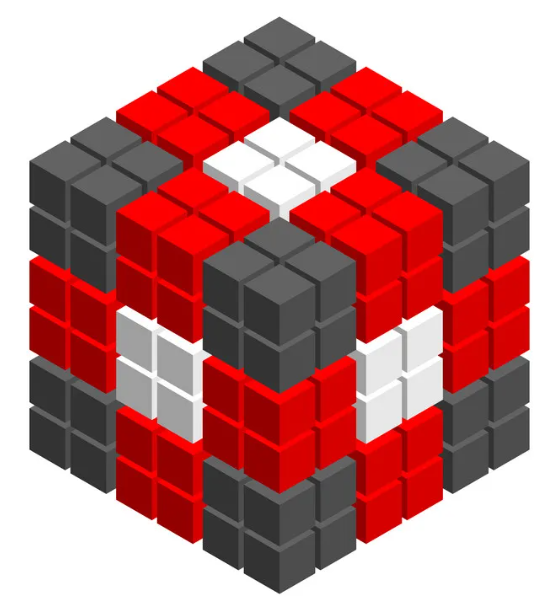

La méthode grid() est une méthode utilisée pour faciliter le calcul des threads, grilles et blocs.  Chaque grille et bloc sont en fait représentés sur 3 dimensions.  Pour le bloc : (cuda.blockDim.x, cuda.blockDim.y, cuda.blockDim.z), la grille elle : (cuda.gridDim.x, cuda.gridDim.y, cuda.gridDim.z)

Une grille est composée de blocs, et chaque blocs contient les threads.  Sur l'image plus haut, la grille serait le gros cube.  Chaque couleur représenterait un bloc et chaque petit cube dans le bloc serait une thread.

On multiplie les 3 valeurs pour obtenir le nombre de blocs dans une grille et le nombre de threads composant un bloc.

Chaque bloc a donc 

`nombre_threads_par_bloc = cuda.blockDim.x * cuda.blockDim.y * cuda.blockDim.z`

Chaque grille a donc

`nombre_blocs = cuda.gridDim.x * cuda.gridDim.y * cuda.gridDim.z`


On représenterait donc normalement un appel à une fonction avec les 3 dimensions pour la grille et les blocs de cette façon:


```
kernel_name[(griddimx, griddimy, griddimz), (blockdimx, blockdimy, blockdimz)](arguments)
```
Donc, dans notre exemple quand on utilise seulement 1024 dans les 2 paramètres c'est l'équivalent de dire que les autres dimensions (y et z) sont égales à 1.


```
cudakernel1[(1024, 1, 1), (1024, 1, 1)](array)
```

CUDA fourni les propriétés suivantes pour permettre d'identifier chacune des threads.

* `cuda.threadIdx.x, cuda.threadIdx.y, cuda.threadIdx.z` donnent les coordonnées (x, y, z) de la thread en cours dans le bloc courant
* `cuda.blockIdx.x, cuda.blockIdx.y, cuda.blockIdx.z` donnent les coordonnées (x, y, z) du bloc courant de la grille.

La position absolue d'une thread est donc calculée ainsi

```
(cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x, 
 cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y,
 cuda.blockIdx.z * cuda.blockDim.z + cuda.threadIdx.z) 
```

Donc cette méthode là serait l'équivalent que d'appeler cuda.grid(1)

```
@cuda.jit
def cudakernel1b(array):
    thread_position = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
    array[thread_position] += 0.5
```





In [ ]:
import numpy as np
from numba import cuda 

%timeit est une fonction "magique" qui permet de mesurer le temps d'exécution d'une fonction.  Elle va lancer la function plusieurs fois et va calculer les temps moyen par boucle.

---

Pour cet exemple on utilise un tableau de nombre aléatoires et on applique des coefficient polynomiaux dessus.  Ex : X exposant 9 + x exposant 8, etc... sur chacune des cellule du tableau.

On mesure ensuite le temps que ca prends pour faire les opérations sur plus de 2 millions de threads.  On compare aussi 2 méthodes provenant de numpy qui semble être équivalentes mais que l'ordre des paramètres est inversé.

In [ ]:
a = np.random.randn(2048 * 1024).astype(np.float32)  # our array
p = np.float32(range(1, 10))   # the coefficients of a polynomial in ascending order
c = p[::-1] # the coefficients of the same polynomial in descending order

print(p, c)

# Let's evaluate the polynomial X**8 + 2 X**7 + 3 X**6 + ... + 8 X + 9 on each cell of the array:
%timeit np.polyval(p, a)  # coefficients first, in descending order, array next
%timeit np.polynomial.polynomial.polyval(a, c) # array first, coefficients next, in ascending order
print(np.polyval(p, a))
# Let's check if the two functions provide the same result:
print('Maximum absolute difference:', np.max(np.abs(np.polyval(p, a) - np.polynomial.polynomial.polyval(a, c))))

# Finally, let's check if we can improve the speed of the second function by using its argument 'tensor'.
# Indeed we don't need to use tensors, so let's set it to False.
%timeit  np.polynomial.polynomial.polyval(a, c, tensor= False)

[1. 2. 3. 4. 5. 6. 7. 8. 9.] [9. 8. 7. 6. 5. 4. 3. 2. 1.]
100 loops, best of 5: 15.5 ms per loop
10 loops, best of 5: 20.5 ms per loop
[12.047674   5.007573   7.0622797 ...  7.5214763  9.588079   5.5418186]
Maximum absolute difference: 0.0
100 loops, best of 5: 14.6 ms per loop


On recrée maintenant une fonction polynomiale mais qui va utiliser le GPU avec CUDA (numba)

In [ ]:
@cuda.jit
def cuda_polyval(result, array, coeffs):
    # Evaluate a polynomial function over an array with Horner's method.
    # The coefficients are given in descending order.
    i = cuda.grid(1) # equivalent to i = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
    val = coeffs[0]
    for coeff in coeffs[1:]:
        val = val * array[i] + coeff
    result[i] = val

On teste la méthode avec un tableau de 2M de cellules.  Les coefficients de 1 à 9 inclusivement.  Un peu comme on avait avec l'exécution précédente.

In [ ]:
array = np.random.randn(2048 * 1024).astype(np.float32)
coeffs = np.float32(range(1, 10))
result = np.empty_like(array)
cuda_polyval[2048, 1024](result, array, coeffs)
numpy_result = np.polyval(coeffs, array)
print('Maximum relative error compared to numpy.polyval:', np.max(np.abs(numpy_result - result) / np.abs(numpy_result)))

Maximum relative error compared to numpy.polyval: 5.9889453e-07


Remarquez le warning indiquant que la copie des données va amener un overhead.  On verra bien l'effet tout à l'heure.


---

Maintenant on va mesurer le temps d'exécution de cette nouvelle fonction en utilisant le GPU.

In [ ]:
%timeit cuda_polyval[2048, 1024](result, array, coeffs)

100 loops, best of 5: 9.57 ms per loop


9.57 ms c'est pas tellement plus rapide que les functions de numpy, on va essayer maintenant d'utiliser les méthodes `cuda.to_device` pour copier les tableaux et valeurs directement sur le GPU.



---



In [ ]:
d_array = cuda.to_device(array)
d_coeffs = cuda.to_device(coeffs)
d_result = cuda.to_device(result)

In [ ]:
%timeit cuda_polyval[2048, 1024](d_result, d_array, d_coeffs)

The slowest run took 8.99 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 167 µs per loop


Si on compare les 2 temps, c'est énorme, on passe de 9570 µs à 106 µs ce qui veut dire que seulement le transfert des données prends une énorme majorité de temps.  1.5% dans cet exemple est le temps pour le kernel, le reste est pour copier les données.



---



Maintenant, on cumule tous les temps ensemble, incluant la copie des données vers la GPU et l'exécution de la fonction.

In [ ]:
%timeit \
d_array = cuda.to_device(array);\
d_coeffs = cuda.to_device(coeffs);\
d_result = cuda.to_device(result);\
cuda_polyval[2048, 1024](d_result, d_array, d_coeffs)

100 loops, best of 5: 5.44 ms per loop


Quand même assez rapide mais on est loin du 100 micro-secondes encore.  Notez qu'on a pas récupéré le résultat, seulement copié les valeurs vers le GPU.  Donc 3+ ms pour la copie, 3+ pour la récupérer à nouveau, on arrive à plus de 7ms.



---

Prochain exemple, utiliser le CPU avec numba pour exécuter exactement la même méthode.  Numba va compiler le code changer les types variables de python en des types fixes et rouler le tout sur du code compilé.

In [ ]:
from numba import jit

@jit
def host_polyval(result, array, coeffs):
    for i in range(len(array)):
        val = coeffs[0]
        for coeff in coeffs[1:]:
            val = val * array[i] + coeff
        result[i] = val

In [ ]:
host_polyval(result, array, coeffs)
print('Maximum absolute difference with numpy.polyval:', np.max(np.abs(np.polyval(coeffs, array) - result)))

Maximum absolute difference with numpy.polyval: 0.0


In [ ]:
%timeit host_polyval(result, array, coeffs)

10 loops, best of 5: 37.5 ms per loop


In [ ]:
def python_polyval(result, array, coeffs):
    for i in range(len(array)):
        val = coeffs[0]
        for coeff in coeffs[1:]:
            val = val * array[i] + coeff
        result[i] = val

In [ ]:
%timeit python_polyval(result, array, coeffs)

1 loop, best of 5: 5.87 s per loop


<table>
<tr>
<th>Type</th>
<th>Temps Moyen</th>
<th>Microsecondes</th>
</tr>
<tr>
<td>Python</td>
<td>5.87 secondes</td>
<td>587,000,000</td>
</tr>
<tr>
<td>Numba (Transpilation)</td>
<td>37.5 millisecondes</td>
<td>37,500</td>
</tr>
<tr>
<td>Numba (GPU)</td>
<td>167 micro secondes</td>
<td>167</td>
</tr>
</table>


Numba réduit consiférablement le temps d'exécution pour exactement la même fonction en python.  Évidemment si on compare les 2 (cuda vs numba) on se rends compte qu'on a un gain de temps significatif à utiliser le GPU.  0,106 millisecondes vs 5 millisecondes en utilisant numba.

Aussi c'est important d'essayer de limiter le plus possible les occasions où l'on transfert des données vers le GPU <==> CPU parce que ca peut influencer grandement le temps d'exécution des calculs.